### Investigation on whether I can Fill the missing values on Fore look doue to RFI with the Aft look

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, create_landmask


In [2]:
windsat_folder = "../../data/raw/daily_Windsat"

# Load all data for both looks
ds = windsat_datacube(windsat_folder, look= None)
ds

<xarray.Dataset> Size: 5GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    imputed_flag    (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) bool 199MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Select the TbToAs, swap dims for visualiztion using cartopy
Tbs = ds.tbtoa.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
Tbs = Tbs.sortby(['lat', 'lon'])
Tbs

<xarray.DataArray 'tbtoa' (day_number: 24, polarization: 2, frequency_band: 2,
                           lat: 720, lon: 1440, swath_sector: 2)> Size: 796MB
dask.array<getitem, shape=(24, 2, 2, 720, 1440, 2), dtype=float32, chunksize=(1, 1, 1, 240, 480, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon         (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * day_number  (day_number) int32 96B 1 2 57 58 84 85 ... 283 323 324 348 349
Dimensions without coordinates: polarization, frequency_band, swath_sector
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

In [4]:
# I need a scatterplot of all data, look = 1 vs look = 0.
# Lets start with values for one day only
dn = ds.day_number.values[10]

# And one specific frequency and swath:
selection_kw = {
    "polarization" : 0,
    "frequency_band" : 1,
    "swath_sector" : 1,
    "day_number": dn
}
fore = Tbs.sel(**selection_kw, look_direction = 0)
aft = Tbs.sel(**selection_kw, look_direction = 1)

From Previous data exploration, we know that aft measurements are more limited in space than fore ones.

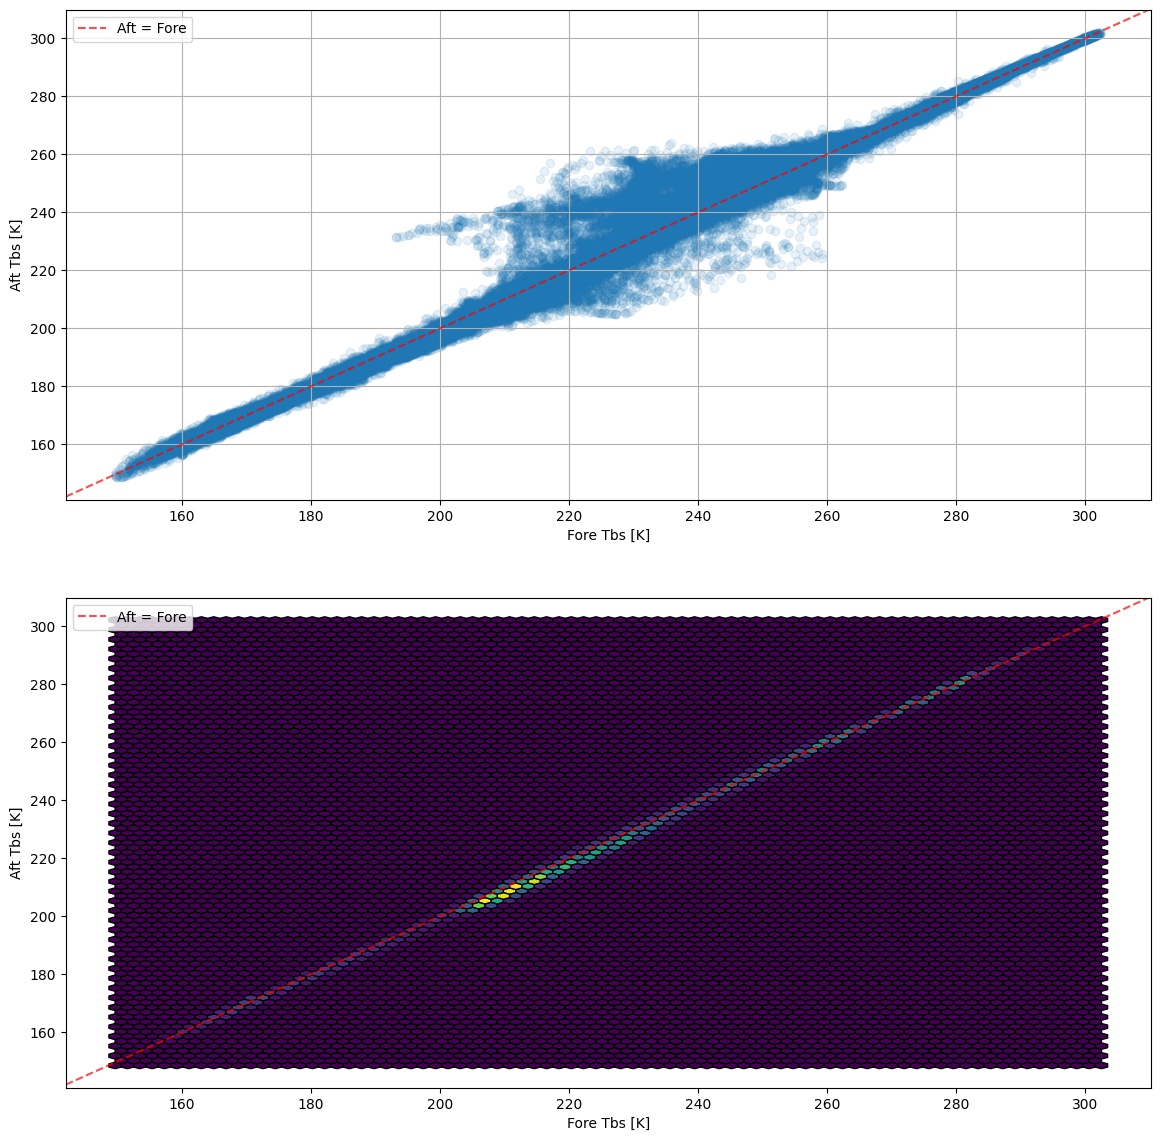

In [5]:
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "Black"

}

abline_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}

fig, axs = plt.subplots(2,1,figsize = (14,14))
ax = axs[0]
ax.scatter(x = fore.values.flatten(), y = aft.values.flatten(), alpha = 0.1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, **abline_kw, label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()
ax.grid()

ax = axs[1]
ax.hexbin(x = fore.values.flatten(), y = aft.values.flatten(),**hexbin_kw)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, **abline_kw, label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()


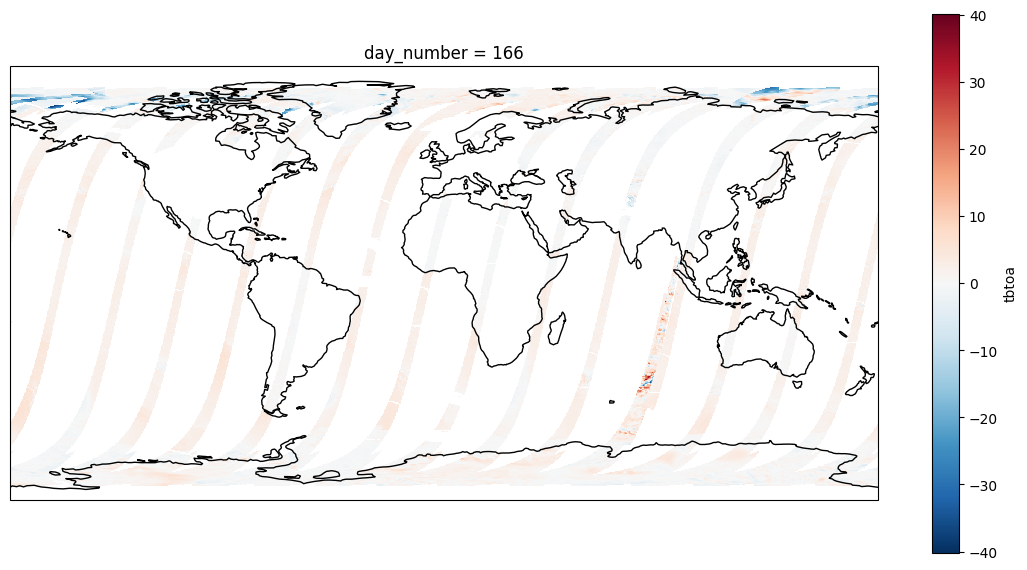

In [6]:
# See the difference in the map:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

diff = fore - aft
diff.plot()
ax.coastlines("110m")

### Tbs over the ocean might have some glint due to the sun which we dont want,

### Also we should filter Tbs over 2ºC

In [7]:
# Landmask
landmask = create_landmask(lon = Tbs.lon, lat= Tbs.lat)
Tbs["landmask"] = (("lat","lon"),landmask.values)

# Tbs = Tbs.where(Tbs.landmask.values == 0)

# Remove values below 2ºC
Tbs = Tbs.where(Tbs > (273.15 + 2))

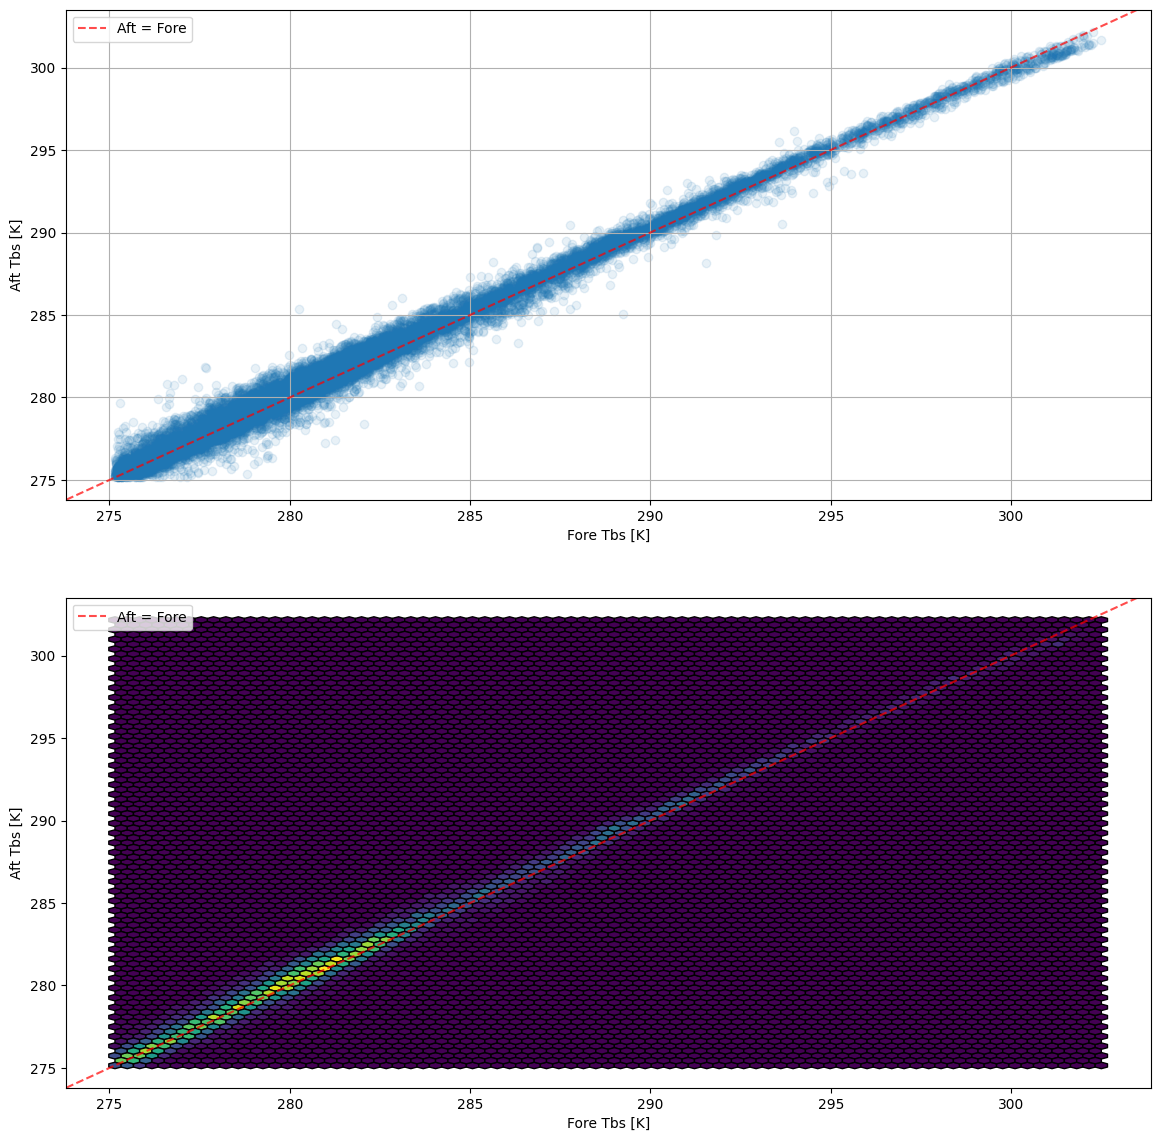

In [8]:
# Lets start with values for one day only
dn = ds.day_number.values[10]

# And one specific frequency and swath:
selection_kw = {
    "polarization" : 0,
    "frequency_band" : 1,
    "swath_sector" : 1,
    "day_number": dn
}

fore = Tbs.sel(**selection_kw, look_direction = 0).where(Tbs.landmask == 0)
aft = Tbs.sel(**selection_kw, look_direction = 1).where(Tbs.landmask == 0)

fig, axs = plt.subplots(2,1,figsize = (14,14))
ax = axs[0]
ax.scatter(x = fore.values.flatten(), y = aft.values.flatten(), alpha = 0.1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, **abline_kw, label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()
ax.grid()

ax = axs[1]
ax.hexbin(x = fore.values.flatten(), y = aft.values.flatten(),**hexbin_kw)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, **abline_kw, label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()

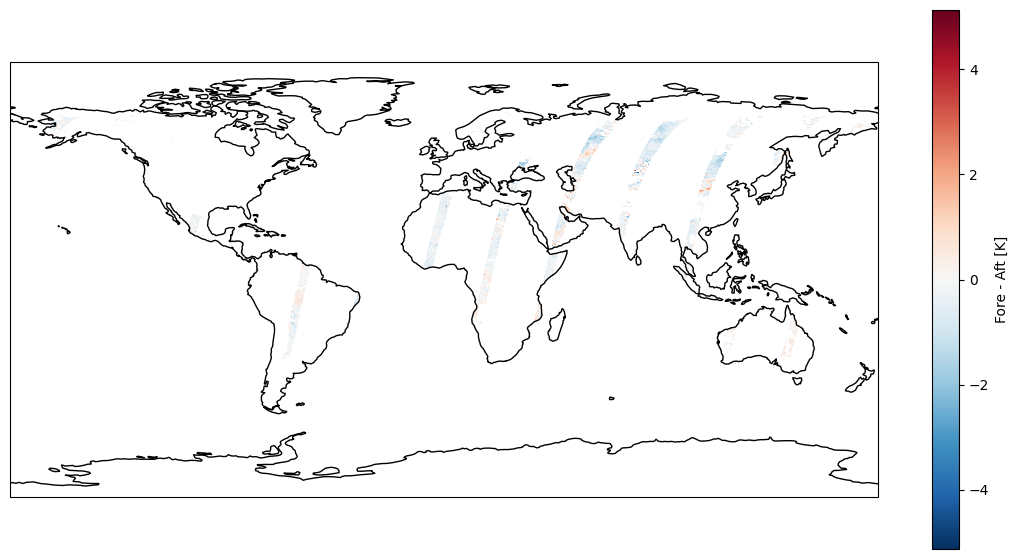

In [9]:
# See the difference in the map:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})
from matplotlib.colors import CenteredNorm
norm = CenteredNorm(vcenter=0)
diff = fore - aft
plot = diff.plot(norm = norm)
cbar = plot.colorbar

cbar.set_label("Fore - Aft [K]")

ax.set_title("")
ax.coastlines("110m")

In [10]:
# Fit a regression line between fore and aft

# Linear Reg does not take nan values:

""" 
    Transform the dataset into pd.DataFrame
    Inner join Fore and Aft (by lat-lon multi index)
    Drop Nans if any
"""

fore_df = fore.to_dataframe().dropna()
aft_df = aft.to_dataframe().dropna()

forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 
forevaft_df

day_number_fore  landmask_fore  tbtoa_fore  day_number_aft  \
lat     lon                                                                   
-33.375 294.625              166            0.0  275.410004             166   
-33.125 293.125              166            0.0  276.037476             166   
        293.375              166            0.0  277.407501             166   
-32.875 141.375              166            0.0  276.065002             166   
        141.625              166            0.0  276.017487             166   
...                          ...            ...         ...             ...   
 69.375 25.375               166            0.0  277.277496             166   
        25.625               166            0.0  277.364990             166   
        25.875               166            0.0  276.709991             166   
        26.125               166            0.0  275.794983             166   
        26.375               166            0.0  275.157501             166   

                 landmask_aft   tbtoa_aft  
lat     lon                                
-33.375 294.625           0.0  276.372498  
-33.125 293.125           0.0  276.007507  
        293.375           0.0  277.797485  
-32.875 141.375           0.0  275.552490  
        141.625           0.0  275.617493  
...                       ...         ...  
 69.375 25.375            0.0  277.197510  
        25.625            0.0  277.092499  
        25.875            0.0  276.497498  
        26.125            0.0  275.795013  
        26.375            0.0  275.167511  

[19799 rows x 6 columns]

In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

reg.fit(X, y)

# Evaluate the model
linear_score = reg.score(X, y)
print("Model score:", linear_score)
print(reg.intercept_, reg.coef_)

Model score: 0.9896267709441084
1.4212646 [0.9941964]


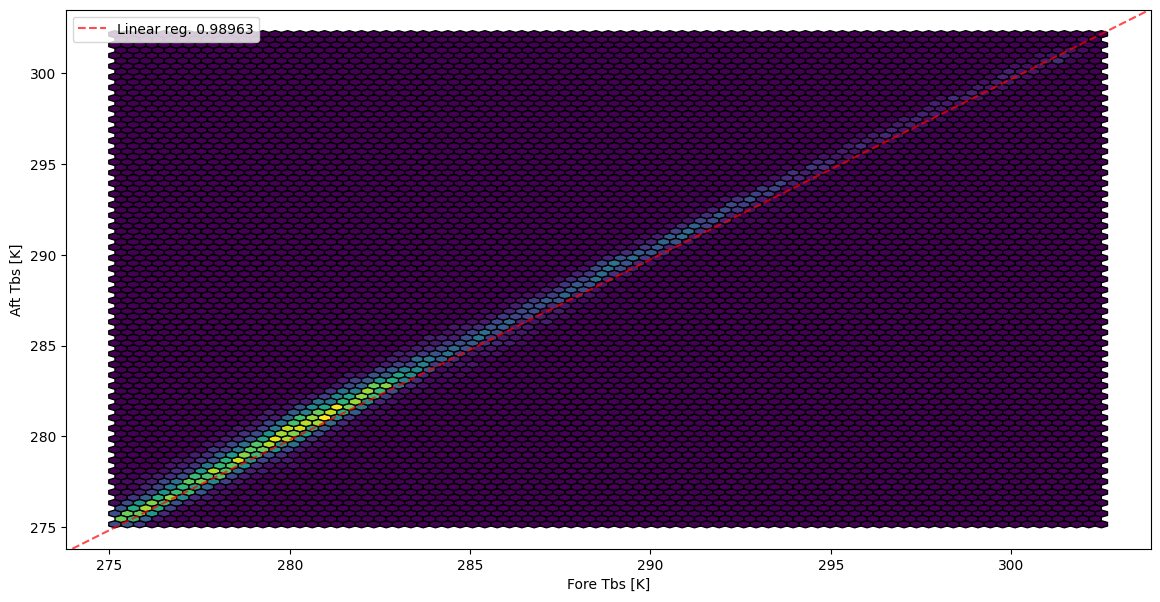

In [12]:
# Plot the regression:
fig, ax = plt.subplots(1,1,figsize = (14,7))

ax.hexbin(x = fore.values.flatten(), y = aft.values.flatten(), **hexbin_kw)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,reg.intercept_), slope= reg.coef_[0], **abline_kw, label=f"Linear reg. {linear_score:.5f}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()

### This looks like it could be improved using a plynomial fit of degree 2

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(X,y)

# Evaluate the model
polynomial_score = model.score(X, y)
print("Model score:", polynomial_score)

# Get the coefficients and intercept
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Model score: 0.9901466350152509
Intercept: 266.96585
Coefficients: [ 0.         -0.86501646  0.00325267]


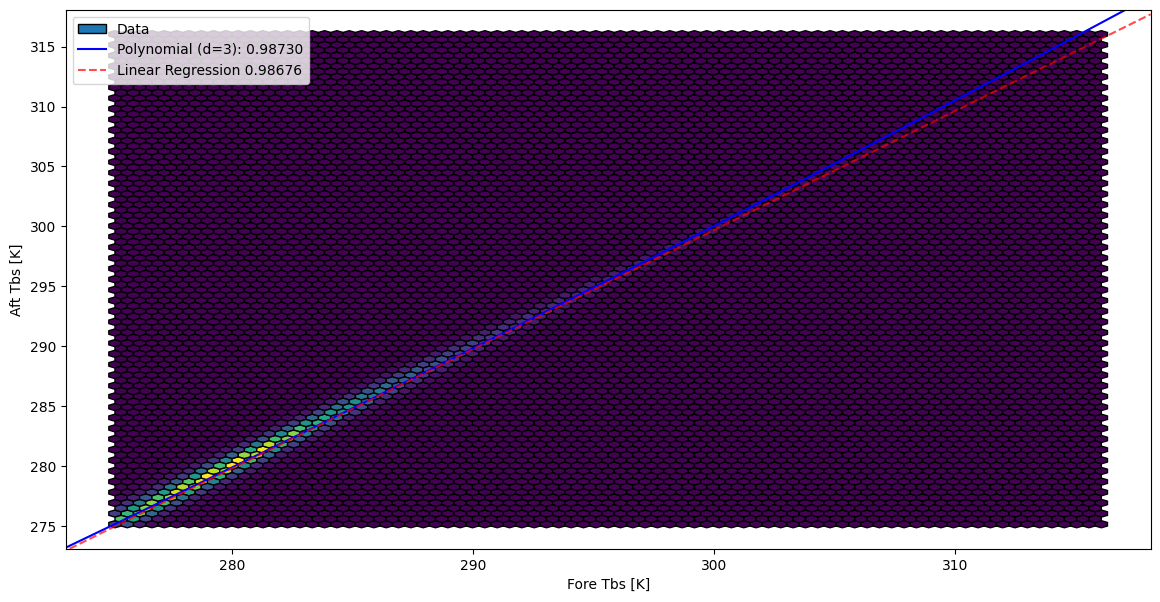

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the regression:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Scatter plot of the original data
ax.hexbin(x=fore.values.flatten(), y=aft.values.flatten(), **hexbin_kw, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Generate a range of x-values for plotting the polynomial regression line
x_range = np.linspace(xlim[0], xlim[1], 500).reshape(-1, 1)

# Predict y-values using the polynomial regression model
y_pred = model.predict(x_range)

# Plot the polynomial regression line
ax.plot(x_range, y_pred, color = "Blue", label=f"Polynomial (d={degree}): {polynomial_score:.5f}")

# Plot the original linear regression line for comparison
ax.axline((0, reg.intercept_), slope=reg.coef_[0] ,**abline_kw, label=f"Linear Regression {linear_score:.5f}")

# Restore the original limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels and legend
ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")
ax.legend()

plt.show()


In [15]:
# Linear Regression score (R^2)
linear_score = reg.score(X, y)
print("Linear Regression R^2 score:", linear_score)

# Polynomial Regression score (R^2)
polynomial_score = model.score(X, y)
print("Polynomial Regression R^2 score:", polynomial_score)


Linear Regression R^2 score: 0.9896267709441084
Polynomial Regression R^2 score: 0.9901466350152509


### With the full dataset.

Plotting a scatterplot of the whole dataset is unfeasable, but we can still fit regression models.

In [16]:
# Now for all days, swaths, polarizations and frequencies:
fore = Tbs.sel(look_direction = 0).where(Tbs.landmask == 0).drop_vars("landmask")
aft = Tbs.sel(look_direction = 1).where(Tbs.landmask == 0).drop_vars("landmask")

In [17]:
fore_df = fore.to_dataframe().dropna()

In [18]:
aft_df = aft.to_dataframe().dropna()

In [19]:
forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 
forevaft_df

tbtoa_fore  \
day_number polarization frequency_band lat     lon     swath_sector               
1          0            0              -48.625 291.875 1             275.877502   
                                               292.125 1             276.602478   
                                               292.375 1             275.524994   
                                       -48.375 291.875 1             275.762482   
                                               292.125 1             276.264984   
...                                                                         ...   
349        1            1               24.375 261.625 1             276.320007   
                                               261.875 1             276.867493   
                                        24.625 80.625  0             275.299988   
                                               261.625 1             275.709991   
                                               261.875 1             275.937500   

                                                                      tbtoa_aft  
day_number polarization frequency_band lat     lon     swath_sector              
1          0            0              -48.625 291.875 1             275.734985  
                                               292.125 1             276.429993  
                                               292.375 1             276.774994  
                                       -48.375 291.875 1             275.422485  
                                               292.125 1             276.005005  
...                                                                         ...  
349        1            1               24.375 261.625 1             277.162476  
                                               261.875 1             277.402496  
                                        24.625 80.625  0             275.417480  
                                               261.625 1             276.875000  
                                               261.875 1             276.677490  

[1488873 rows x 2 columns]

In [20]:
# Linear and polynomial reg.
X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

linear_reg = LinearRegression()
degree = 3
model = model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

linear_reg.fit(X,y)
model.fit(X,y)

# Linear Regression score (R^2)
linear_score = reg.score(X, y)
print("Linear Regression R^2 score:", linear_score)

# Polynomial Regression score (R^2)
polynomial_score = model.score(X, y)
print("Polynomial Regression R^2 score:", polynomial_score)


Linear Regression R^2 score: 0.9867644599990402
Polynomial Regression R^2 score: 0.9872954843147241


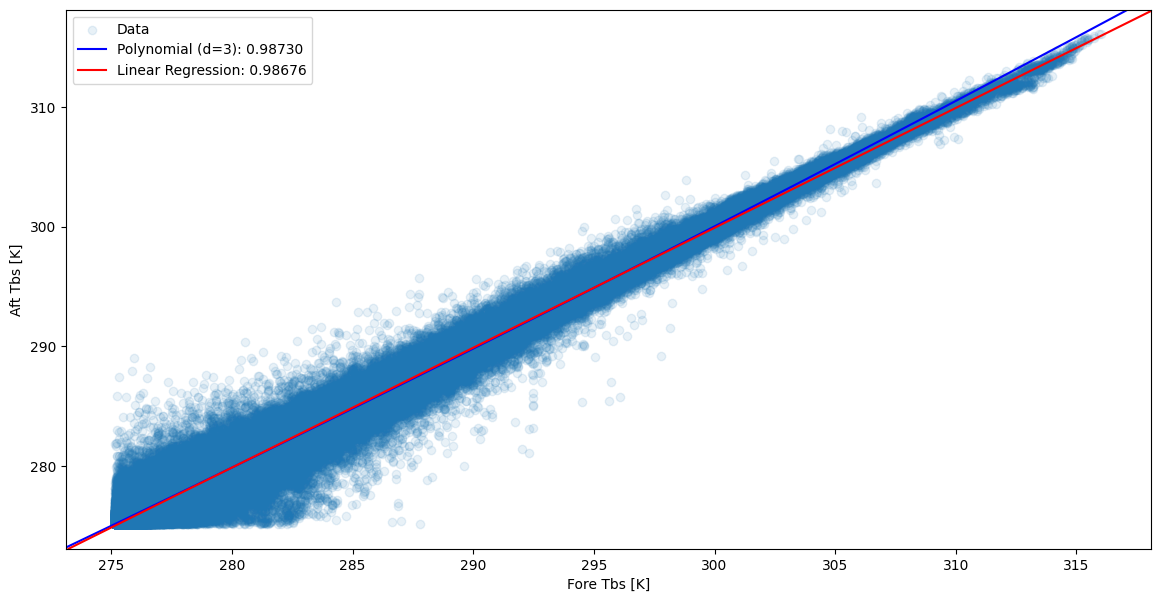

In [21]:
# Can I plot this ? 

# Plot the regression:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Scatter plot of the original data
ax.scatter(x=X, y=y, alpha=0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Generate a range of x-values for plotting the polynomial regression line
x_range = np.linspace(xlim[0], xlim[1], 500).reshape(-1, 1)

# Predict y-values using the polynomial regression model
y_pred = model.predict(x_range)

# Plot the polynomial regression line
ax.plot(x_range, y_pred, color='Blue', label=f"Polynomial (d={degree}): {polynomial_score:.5f}")

# Plot the original linear regression line for comparison
ax.axline((0, linear_reg.intercept_), slope=linear_reg.coef_[0], color="Red", label=f"Linear Regression: {linear_score:.5f}")

# Restore the original limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels and legend
ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")
ax.legend()

plt.show()

### This data representation if missleading, the color does not accurately represent the density of points

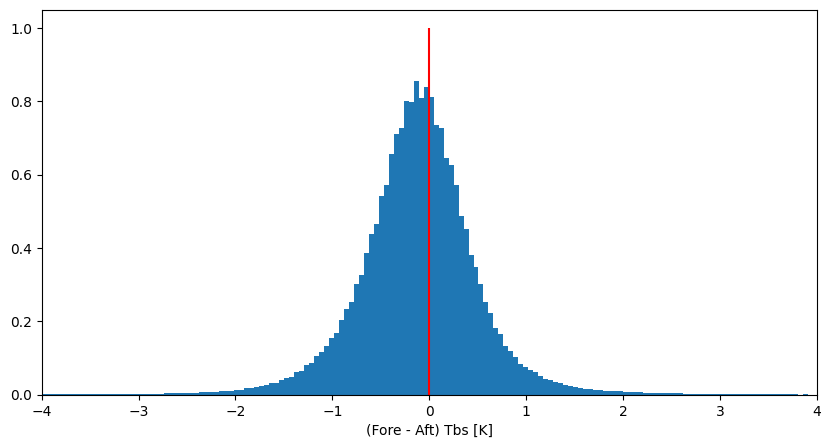

In [22]:
# Histogram of Fore - aft instead
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(x = forevaft_df["tbtoa_fore"] - forevaft_df["tbtoa_aft"], bins = 500, density= True)

ax.set_xlim([-4,4])
ax.set_xlabel("(Fore - Aft) Tbs [K]")

ax.vlines(x = 0, ymin = 0, ymax = 1, color = "Red")
plt.show()


With the simple linear model we can impute missing values with reasonable accuracy (~ 2K) over the US with a simple linear model

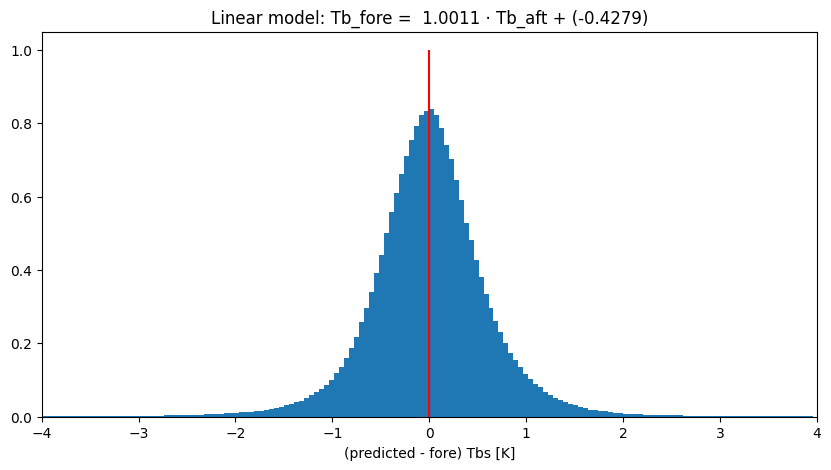

In [23]:
# Predict with the linear model
linear_predictions = linear_reg.predict(X)

# Histogram of Fore - aft instead
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(x = linear_predictions - forevaft_df["tbtoa_fore"], bins = 500, density= True)

ax.set_xlim([-4,4])
ax.set_xlabel("(predicted - fore) Tbs [K]")
ax.set_title(f"Linear model: Tb_fore =  {linear_reg.coef_[0]:.4f} · Tb_aft + ({linear_reg.intercept_:.4f})")
ax.vlines(x = 0, ymin = 0, ymax = 1, color = "Red")
plt.show()

In [24]:
# MSE of the linear model Tb_fore = LM( Tb_aft )
from sklearn.metrics import mean_squared_error

mse_linear = mean_squared_error(y, linear_predictions)
print("Linear Regression MSE:", mse_linear)


Linear Regression MSE: 0.4251493


In [25]:
# Coeficients:

# Linear model
print("Linear model")
print(reg.intercept_, reg.coef_)
print("\n")

# Get the coefficients and intercept poly fit
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_
print(f"Poly fit D = {degree}")
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Linear model
1.4212646 [0.9941964]


Poly fit D = 3
Intercept: 147.64323
Coefficients: [ 0.0000000e+00 -1.4617714e-01  2.6060522e-03 -1.4188843e-06]


--- 

Do the same thing but segregate the frequencies and polarizations

In [28]:
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_squared_error

import numpy as np

In [3]:
windsat_folder = "../../data/raw/daily_Windsat"

# Load all data for both looks
ds = windsat_datacube(windsat_folder, look= "keep")

# Create a landmask to remove the ocean.
landmask = create_landmask(lon = ds.lon.values, lat= ds.lat.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds = ds.where(ds.landmask == 0)

# Remove values where ERA5 Land is greater than 2ºC
ds = ds.where(ds.surtep_ERA5 > (273.15 + 2))
ds

<xarray.Dataset> Size: 8GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid, latitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 720, 360, 1), meta=np.ndarray>
    latitude        (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    node            (day_number, swath_sector, latitude_grid, longitude_grid) float64 398MB dask.array<chunksize=(1, 1, 360, 720), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 398MB dask.array<chunksize=(1, 2, 360, 720, 1), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 398MB dask.array<chunksize=(1, 2, 360, 720, 1), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 398MB dask.array<chunksize=(1, 2, 360, 720, 1), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) float64 796MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    landmask        (latitude_grid, longitude_grid, day_number, swath_sector) float64 398MB dask.array<chunksize=(360, 720, 1, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [61]:
# Select the TbToAs, swap dims for visualiztion using cartopy
Tbs = ds.tbtoa.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
Tbs = Tbs.sortby(['lat', 'lon'])


In [62]:
# And one specific frequency and swath:
selection_kw = {
    "polarization" : 0,
    "frequency_band" : 0,
    "swath_sector" : 0,
}
fore = Tbs.sel(**selection_kw, look_direction = 0)
aft = Tbs.sel(**selection_kw, look_direction = 1)

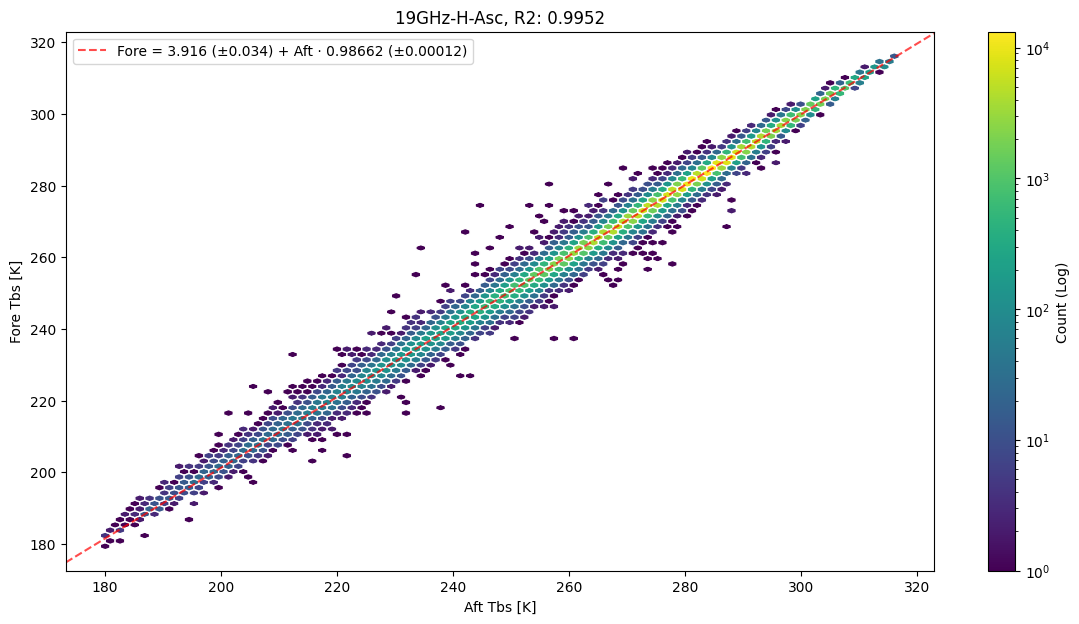

In [63]:
# Key Words for plots
hexbinnorm = LogNorm(vmin= 1)
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}

abline_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
# Id to label for labels
pol2label = {
    0 : "H",
    1 : "V"
}

freq2label = {
    0 : "19GHz",
    1 : "37GHz"
}

swath2label = {
    0 : "Asc",
    1 : "Des"
}

p,f,s = selection_kw.values()

# Turn them into dataframes for linear reg
fore_df = fore.to_dataframe().dropna()
aft_df = aft.to_dataframe().dropna()

forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 

reg = LinearRegression()

X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

reg.fit(X, y)

# Evaluate the model
linear_score = reg.score(X, y)

n = len(y)
mse = mean_squared_error(y, y_pred=reg.predict(X))
sigma_squared = mse
x_mean = np.mean(X)
X_centered = X - x_mean

# Statistical Errors
se_beta = np.sqrt(sigma_squared / np.sum(X_centered ** 2))
se_intercept = np.sqrt(sigma_squared * (1/n + x_mean**2 / np.sum(X_centered ** 2)))

# Calculate the number of representative decimals
def representative_decimals(value):
    if value == 0:
        return 4
    else:
        return max(1, -int(np.floor(np.log10(abs(value)))) + 1)


# Format each coeficient to show in the plot
intercept_str = f"{reg.intercept_:.{representative_decimals(se_intercept)}f}"
se_intercept_str = f"{se_intercept:.{representative_decimals(se_intercept)}f}"

coef_str = f"{reg.coef_[0]:.{representative_decimals(se_beta)}f}"
se_coef_str = f"{se_beta:.{representative_decimals(se_beta)}f}"
linelabel = f"Fore = {intercept_str} (±{se_intercept_str}) + Aft · {coef_str} (±{se_coef_str})"

# Standard error of the prediction TODO: remove this, its unused.
# def se_prediction(x, X, sigma_squared, n, x_mean):
#     return np.sqrt(
#         sigma_squared * (
#             1 + 1/n + ((x - x_mean) ** 2) / np.sum((X - x_mean) ** 2)
#         )
#     )

# Plot
fig, ax = plt.subplots(1,1,figsize = (14,7))

ax.hexbin(x = aft.values.flatten(), y = fore.values.flatten(),**hexbin_kw)

# Hexbin colorbar
cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# LR plot
ax.axline((0,reg.intercept_), slope= reg.coef_[0], **abline_kw, label=linelabel)

# Axis format
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Aft Tbs [K]")
ax.set_ylabel("Fore Tbs [K]")
ax.set_title(f"{freq2label[f]}-{pol2label[p]}-{swath2label[s]}, R2: {linear_score:.4f}")

ax.legend()

polarization : 0
frequency_band : 0
swath_sector : 0


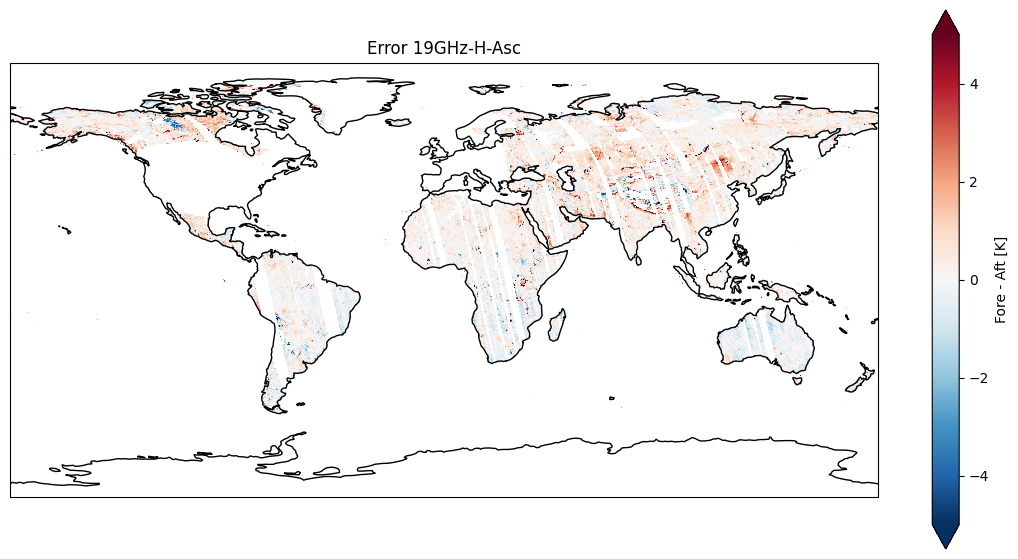

In [64]:
# Localización geográfica de los errores:
# See the difference in the map:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})
from matplotlib.colors import CenteredNorm
norm = CenteredNorm(vcenter=0, halfrange= 5)
diff = fore - aft
diff = diff.mean(dim="day_number")

plot = diff.plot(norm = norm)
cbar = plot.colorbar

cbar.set_label("Fore - Aft [K]")

ax.set_title(f"Error {freq2label[f]}-{pol2label[p]}-{swath2label[s]}")
ax.coastlines("110m")

for key, value in selection_kw.items():
    print(f"{key} : {value}")


In [38]:
# Turn them into dataframes for linear reg
fore_df = fore.to_dataframe().dropna()
aft_df = aft.to_dataframe().dropna()

forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 

In [39]:
# Linear Regression with all the data for this Frequency + Polarization:
reg = LinearRegression()

X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

reg.fit(X, y)

# Evaluate the model
linear_score = reg.score(X, y)
print("Model R2 score:", linear_score)
print(reg.intercept_, reg.coef_)

Model R2 score: 0.9952322917694538
3.915619 [0.9866209]


--- 

Do this for all combinations of Swath, Polarization and Frequency (2x2x2)

Fitting selection H-19GHz-Asc.
Fitting selection H-19GHz-Des.
Fitting selection H-36GHz-Asc.
Fitting selection H-36GHz-Des.
Fitting selection V-19GHz-Asc.
Fitting selection V-19GHz-Des.
Fitting selection V-36GHz-Asc.
Fitting selection V-36GHz-Des.


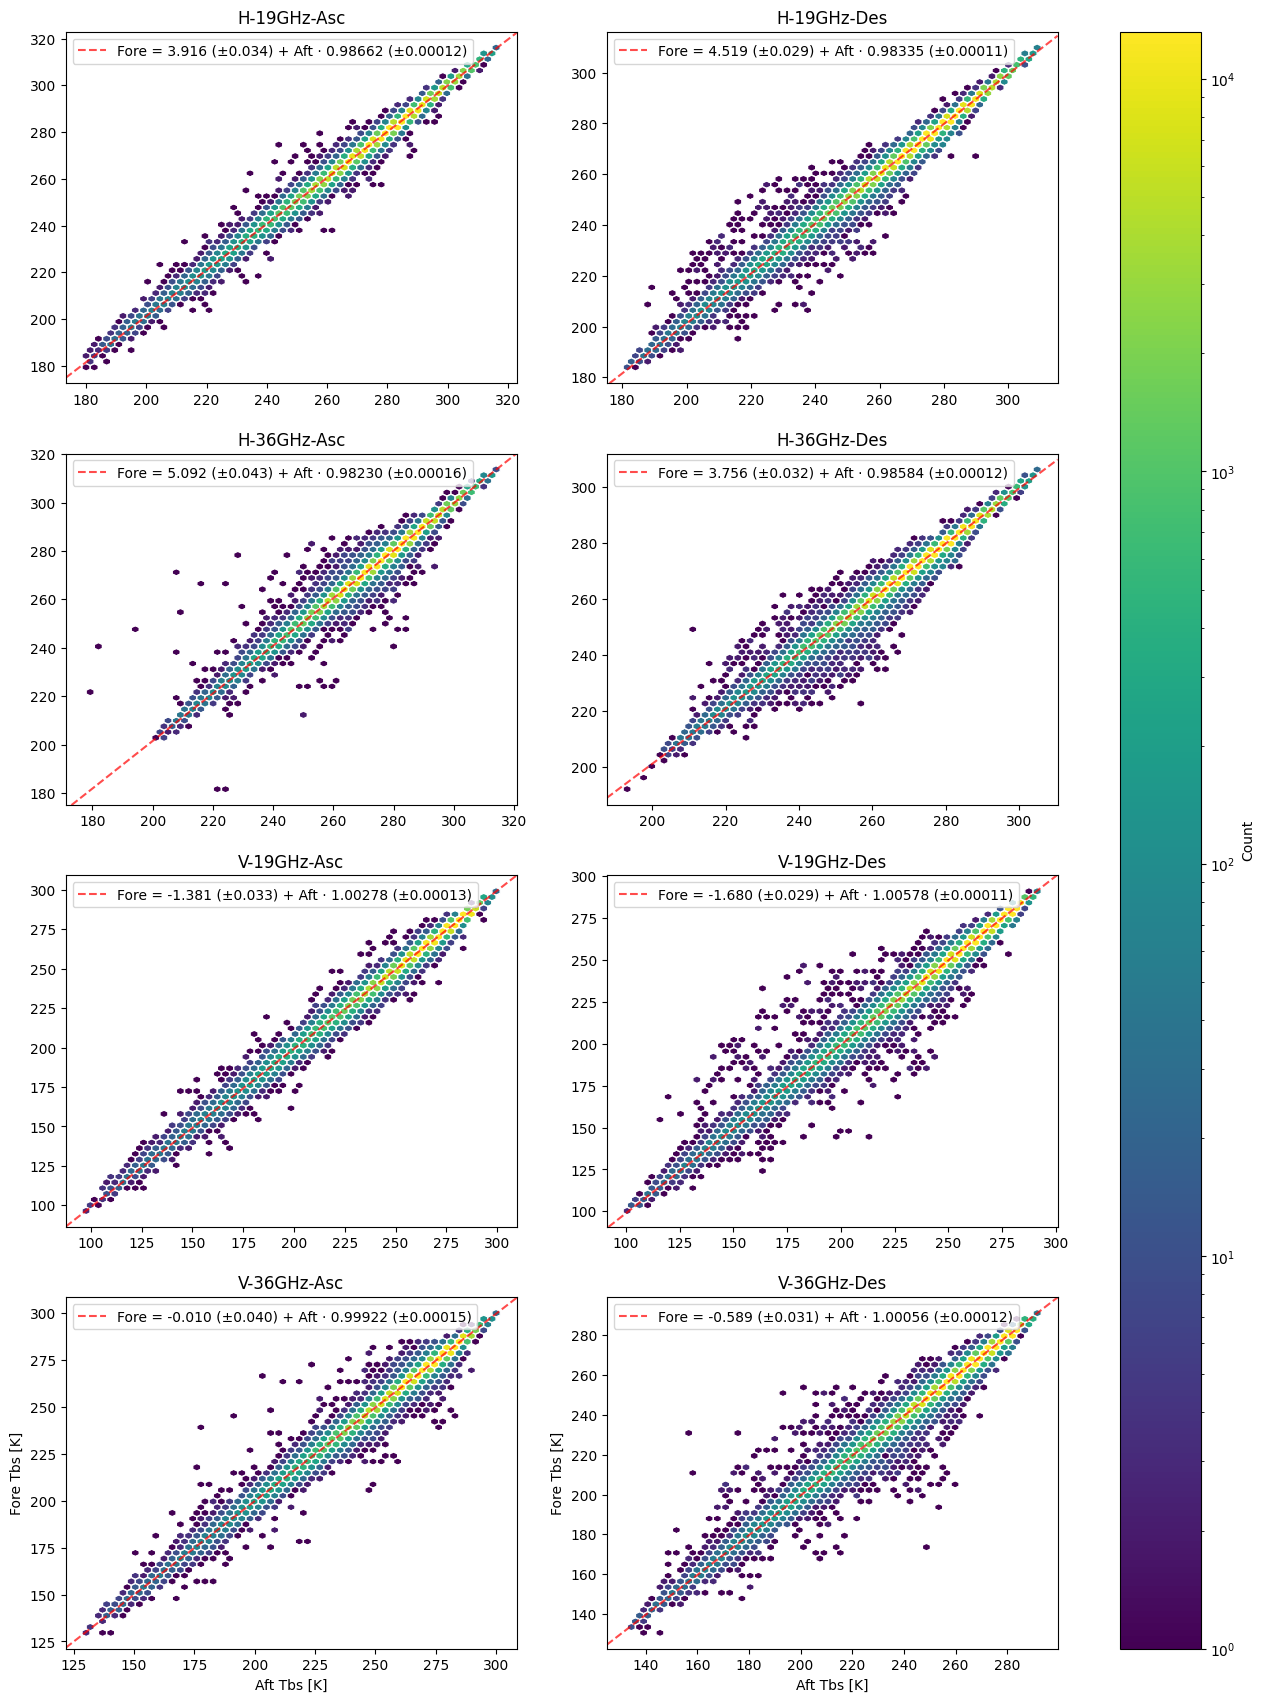

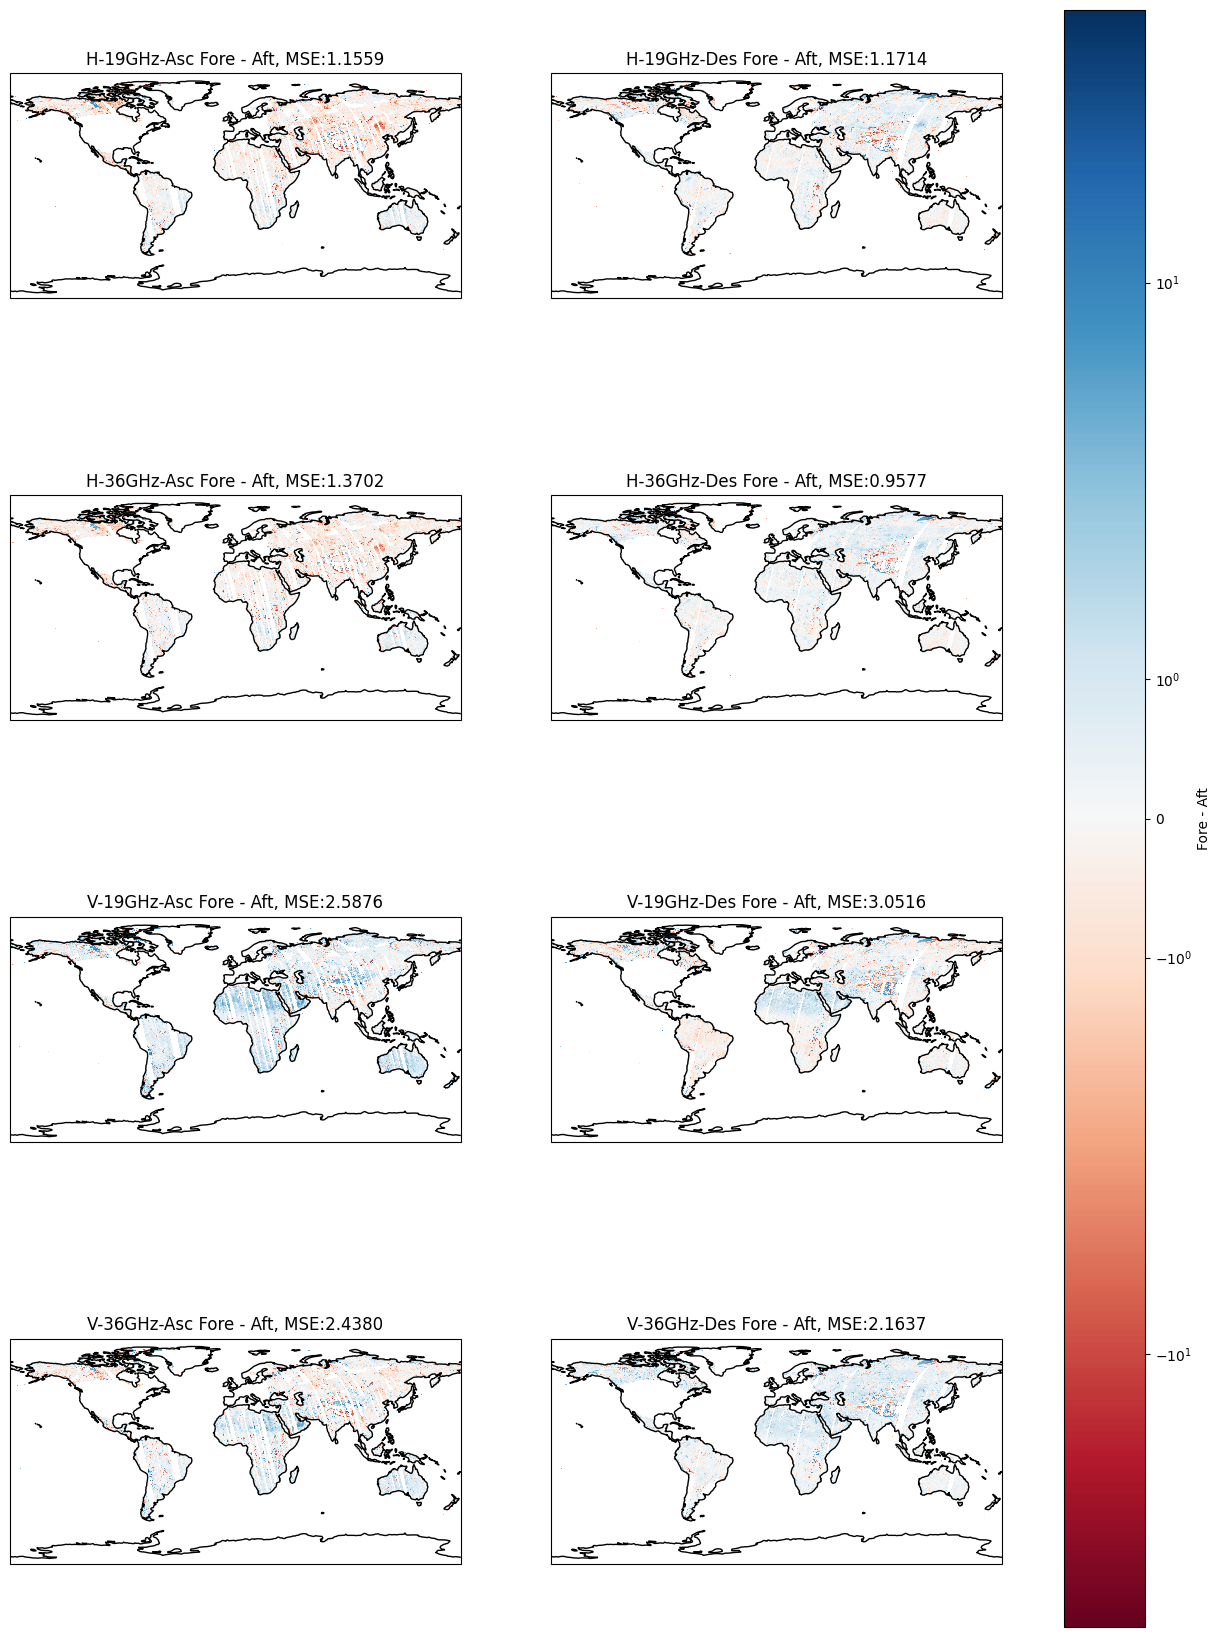

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from matplotlib.colors import CenteredNorm
from matplotlib.colors import SymLogNorm
from matplotlib.cm import ScalarMappable

import pandas as pd

polarizations =  [0,1] # H,V
frequency_bands = [0,1] # Ku, Ka
swath_sectors = [0,1] # Asc(6pm) Des(6am)

# pol2label = {
#     0 : "H",
#     1 : "V"
# }

# freq2label = {
#     0 : "19GHz",
#     1 : "36GHz"
# }

# swath2label = {
#     0 : "Asc",
#     1 : "Des"
# }

windsat_folder = "../../data/raw/daily_Windsat"
# Load all data for both looks
ds = windsat_datacube(windsat_folder, look= "keep")

# Create a landmas to remove the ocean.
landmask = create_landmask(lon = ds.lon.values, lat = ds.lat.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds = ds.where(ds.landmask == 0)

# Remove values where ERA5 Land is greater than 2ºC
ds = ds.where(ds.surtep_ERA5 > (273.15 + 2))

# Select the TbToAs, swap dims for visualiztion using cartopy
Tbs = ds.tbtoa.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
Tbs = Tbs.sortby(['lat', 'lon'])


# Hexbin plots
fig1, axs1 = plt.subplots(4,2,figsize = (16,21))

# Error maps
fig2, axs2 = plt.subplots(4,2,figsize = (16,21), subplot_kw={"projection": ccrs.PlateCarree()})

hexbin_kw = {
    "gridsize" : 50,
    "edgecolors": "White",
    "norm" : hexbinnorm
}

abline_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}

# Save the coeficients in this table:

results_df = pd.DataFrame()

for p in polarizations:
    for f in frequency_bands:
        for s in swath_sectors:

            # Binary conversion to plot number
            n_plot = s + f*2 + p*4

            # plot colocation
            nrow = n_plot // 2
            ncol = n_plot % 2

            selection_kw = {
                "polarization" : p,
                "frequency_band" : f,
                "swath_sector" : s,
            }
            print(f"Fitting selection {pol2label[p]}-{freq2label[f]}-{swath2label[s]}.")

            # Select the transformed dataframe 
            fore = Tbs.sel(**selection_kw, look_direction = 0)
            aft = Tbs.sel(**selection_kw, look_direction = 1)

            # Fit a linear regression
            fore_df = fore.to_dataframe().dropna()
            aft_df = aft.to_dataframe().dropna()

            forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 

            reg = LinearRegression()
            X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
            y=forevaft_df["tbtoa_fore"].values

            reg.fit(X, y)

            # Evaluate the model
            linear_score = reg.score(X, y)

            linear_predictions = reg.predict(X)
            mse_linear = mean_squared_error(y, linear_predictions)

            # Statistics
            n = len(y)
            mse = mean_squared_error(y, y_pred=reg.predict(X))
            sigma_squared = mse
            x_mean = np.mean(X)
            X_centered = X - x_mean

            # Statistical Errors
            se_beta = np.sqrt(sigma_squared / np.sum(X_centered ** 2))
            se_intercept = np.sqrt(sigma_squared * (1/n + x_mean**2 / np.sum(X_centered ** 2)))

            # Calculate the number of representative decimals
            def representative_decimals(value):
                if value == 0:
                    return 4
                else:
                    return max(1, -int(np.floor(np.log10(abs(value)))) + 1)


            # Format each coeficient to show in the plot
            intercept_str = f"{reg.intercept_:.{representative_decimals(se_intercept)}f}"
            se_intercept_str = f"{se_intercept:.{representative_decimals(se_intercept)}f}"

            coef_str = f"{reg.coef_[0]:.{representative_decimals(se_beta)}f}"
            se_coef_str = f"{se_beta:.{representative_decimals(se_beta)}f}"
            linelabel = f"Fore = {intercept_str} (±{se_intercept_str}) + Aft · {coef_str} (±{se_coef_str})"

            
            # Hexbin plot
            ax1 = axs1[nrow, ncol]
            
            ax1.hexbin(x = aft.values.flatten(), y = fore.values.flatten(), **hexbin_kw)

            xlim = ax1.get_xlim()
            ylim = ax1.get_ylim()

            # Regression plot
            ax1.axline((0,reg.intercept_), slope= reg.coef_[0], **abline_kw, label=linelabel)

            ax1.set_xlim(xlim)
            ax1.set_ylim(ylim)

            if nrow == 3:
                ax1.set_xlabel("Aft Tbs [K]")
                ax1.set_ylabel("Fore Tbs [K]")

            ax1.set_title(f"{pol2label[p]}-{freq2label[f]}-{swath2label[s]}")

            ax1.legend(loc = "upper left")

            # Map plot
            ax2 = axs2[nrow, ncol]

            norm = SymLogNorm(linthresh=2.5)
            diff = fore - aft
            diff = diff.mean(dim="day_number")

            plot = diff.plot(norm = norm, ax = ax2, add_colorbar = False)
            ax2.set_title(f"{pol2label[p]}-{freq2label[f]}-{swath2label[s]} Fore - Aft, MSE:{mse_linear:.4f}")

            ax2.coastlines("110m")

            subset_df = pd.DataFrame({
                "subset_name" : [f"{freq2label[f]}-{pol2label[p]}-{swath2label[s]}"],
                "intercept" : [f"{intercept_str} (±{se_intercept_str})"],
                "slope" : [f"{coef_str} (±{se_coef_str})"],
                "R2 score": [f"{linear_score:.4f}"],
            })


            results_df = pd.concat([subset_df,results_df])
            
fig1.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=axs1, orientation='vertical', label = "Count")

fig2.colorbar(ScalarMappable(norm=norm,cmap="RdBu"), ax = axs2, orientation='vertical', label = "Fore - Aft")

                        

In [55]:
results_df

subset_name        intercept               slope R2 score
0  36GHz-V-Des  -0.589 (±0.031)  1.00056 (±0.00012)   0.9928
0  36GHz-V-Asc  -0.010 (±0.040)  0.99922 (±0.00015)   0.9928
0  19GHz-V-Des  -1.680 (±0.029)  1.00578 (±0.00011)   0.9935
0  19GHz-V-Asc  -1.381 (±0.033)  1.00278 (±0.00013)   0.9950
0  36GHz-H-Des   3.756 (±0.032)  0.98584 (±0.00012)   0.9922
0  36GHz-H-Asc   5.092 (±0.043)  0.98230 (±0.00016)   0.9919
0  19GHz-H-Des   4.519 (±0.029)  0.98335 (±0.00011)   0.9936
0  19GHz-H-Asc   3.916 (±0.034)  0.98662 (±0.00012)   0.9952

In [57]:
print(results_df.to_latex(index=False))

\begin{tabular}{llll}
\toprule
subset_name & intercept & slope & R2 score \\
\midrule
36GHz-V-Des & -0.589 (±0.031) & 1.00056 (±0.00012) & 0.9928 \\
36GHz-V-Asc & -0.010 (±0.040) & 0.99922 (±0.00015) & 0.9928 \\
19GHz-V-Des & -1.680 (±0.029) & 1.00578 (±0.00011) & 0.9935 \\
19GHz-V-Asc & -1.381 (±0.033) & 1.00278 (±0.00013) & 0.9950 \\
36GHz-H-Des & 3.756 (±0.032) & 0.98584 (±0.00012) & 0.9922 \\
36GHz-H-Asc & 5.092 (±0.043) & 0.98230 (±0.00016) & 0.9919 \\
19GHz-H-Des & 4.519 (±0.029) & 0.98335 (±0.00011) & 0.9936 \\
19GHz-H-Asc & 3.916 (±0.034) & 0.98662 (±0.00012) & 0.9952 \\
\bottomrule
\end{tabular}



Fitting selection 19GHz-Asc.
Model R2 score: 0.9951879184501589
intercept: -1.4672 Slope 1.0046
Linear Regression MSE: 2.0722


Fitting selection 19GHz-Des.
Model R2 score: 0.9942514061166142
intercept: -0.2840 Slope 1.0007
Linear Regression MSE: 2.1496


Fitting selection 36GHz-Asc.
Model R2 score: 0.992941256125165
intercept: 0.6237 Slope 0.9977
Linear Regression MSE: 1.9733


Fitting selection 36GHz-Des.
Model R2 score: 0.9932526004135891
intercept: -0.2563 Slope 0.9999
Linear Regression MSE: 1.5987




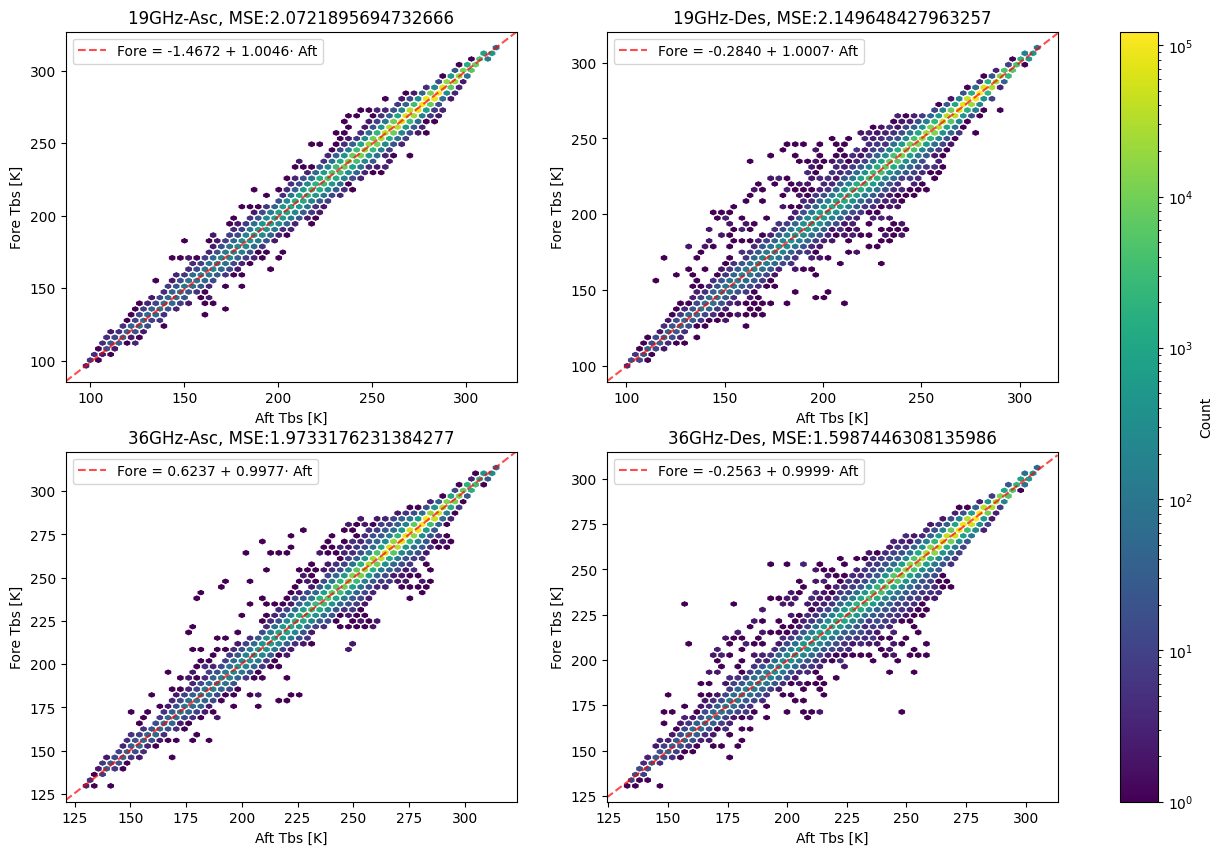

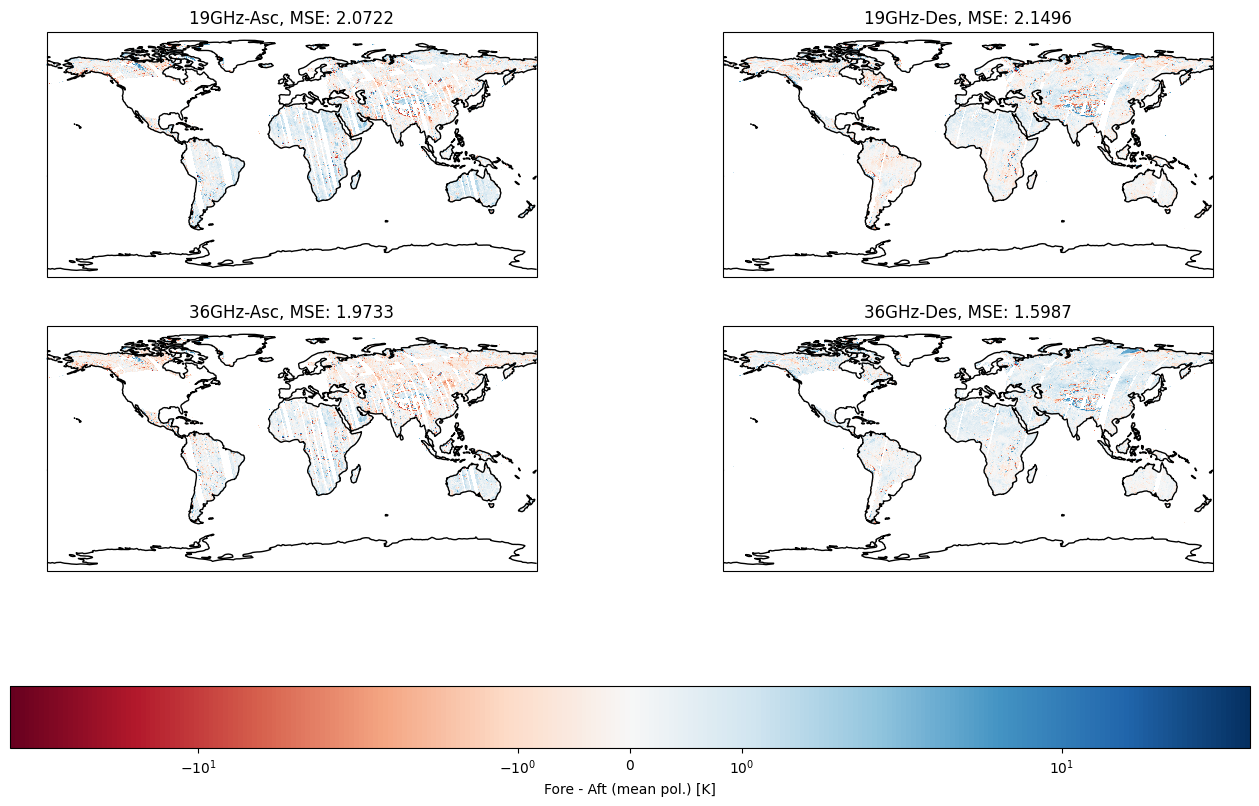

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from matplotlib.colors import CenteredNorm
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable


# polarizations =  [0,1] # H,V
frequency_bands = [0,1] # Ku, Ka
swath_sector = [0,1] # Asc(6pm) Des(6am)

freq2label = {
    0 : "19GHz",
    1 : "36GHz"
}

swath2label = {
    0 : "Asc",
    1 : "Des"
}

windsat_folder = "../../data/raw/daily_Windsat"
# Load all data for both looks
ds = windsat_datacube(windsat_folder, look= "keep")

# Create a landmas to remove the ocean.
landmask = create_landmask(lon = ds.lon.values, lat= ds.lat.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds = ds.where(ds.landmask == 0)

# Remove values where ERA5 Land is greater than 2ºC
ds = ds.where(ds.surtep_ERA5 > (273.15 + 2))

# Select the TbToAs, swap dims for visualiztion using cartopy
Tbs = ds.tbtoa.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
Tbs = Tbs.sortby(['lat', 'lon'])

# Hexbin plots
fig1, axs1 = plt.subplots(2,2,figsize = (16,10))

# Error maps
fig2, axs2 = plt.subplots(2,2,figsize = (16,10), subplot_kw={"projection": ccrs.PlateCarree()})

abline_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}

# Aggregate in polarization
for f in frequency_bands:
    for s in swath_sector:

        # Binary conversion to plot number
        n_plot = s + f*2 

        # plot colocation
        nrow = n_plot // 2
        ncol = n_plot % 2

        selection_kw = {
            "frequency_band" : f,
            "swath_sector" : s,
        }
        print(f"Fitting selection {freq2label[f]}-{swath2label[s]}.")

        # Select the transformed dataframe 
        fore = Tbs.sel(**selection_kw, look_direction = 0)
        aft = Tbs.sel(**selection_kw, look_direction = 1)

        # Fit a linear regression
        fore_df = fore.to_dataframe().dropna()
        aft_df = aft.to_dataframe().dropna()

        forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 

        reg = LinearRegression()
        X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
        y=forevaft_df["tbtoa_fore"].values

        reg.fit(X, y)

        # Evaluate the model
        linear_score = reg.score(X, y)
        print("Model R2 score:", linear_score)
        print(f"intercept: {reg.intercept_:.4f}", f"Slope {reg.coef_[0]:.4f}")

        linear_predictions = reg.predict(X)
        mse_linear = mean_squared_error(y, linear_predictions)
        print(f"Linear Regression MSE: {mse_linear:.4f}")
        
        # Hexbin plot
        ax1 = axs1[nrow, ncol]
        
        hexbinnorm = LogNorm()
        hexbin_kw = {
            "gridsize" : 50,
            "edgecolors": "White",
            "norm" : hexbinnorm
        }
        ax1.hexbin(x = aft.values.flatten(), y = fore.values.flatten(), **hexbin_kw)
        ax1.set_title(f"{freq2label[f]}-{swath2label[s]}, MSE:{mse_linear}")


        # Hexbin colorbar
        # cbar = plt.colorbars(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax1, orientation='vertical', pad=0.05, label = "Count (Log)")

        xlim = ax1.get_xlim()
        ylim = ax1.get_ylim()

        # Regression plot
        ax1.axline((0,reg.intercept_), slope= reg.coef_[0], **abline_kw, label=f"Fore = {reg.intercept_:.4f} + {reg.coef_[0]:.4f}· Aft")

        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)


        ax1.set_xlabel("Aft Tbs [K]")
        ax1.set_ylabel("Fore Tbs [K]")

        ax1.legend(loc = "upper left")

        # Map plot
        ax2 = axs2[nrow, ncol]

        norm = SymLogNorm(linthresh=2.5)
        diff = fore - aft
        diff = diff.mean(dim=["day_number", "polarization"])

        diff.plot(norm = norm , ax = ax2, add_colorbar = False)
        ax2.set_title(f"{freq2label[f]}-{swath2label[s]}, MSE: {mse_linear:.4f}")

        # cbar = plot.colorbar

        # cbar.set_label("Daily mean (Fore - Aft) [K]")

        ax2.coastlines("110m")
        print("\n")

fig1.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=axs1, orientation='vertical', label = "Count")

fig2.colorbar(ScalarMappable(norm=norm, cmap = "RdBu"), ax = axs2, orientation='horizontal', label = "Fore - Aft (mean pol.) [K]")

                        

In [1]:
import numpy as np
import pandas as pd

# Datos iniciales en formato de lista
data = {
    'subset_name': ['36GHz-V-Des', '36GHz-V-Asc', '19GHz-V-Des', '19GHz-V-Asc', 
                    '36GHz-H-Des', '36GHz-H-Asc', '19GHz-H-Des', '19GHz-H-Asc'],
    'intercept': [-0.589, -0.010, -1.680, -1.381, 3.756, 5.092, 4.519, 3.916],
    'slope': [1.00056, 0.99922, 1.00578, 1.00278, 0.98584, 0.98230, 0.98335, 0.98662],
    'R2 score': [0.9928, 0.9928, 0.9935, 0.9950, 0.9922, 0.9919, 0.9936, 0.9952]
}

# Crear el dataframe
df = pd.DataFrame(data)

# Definir las dimensiones de la matriz 3D
polarizaciones = ['V', 'H']
frecuencias = ['36GHz', '19GHz']
sectores = ['Des', 'Asc']

# Crear una matriz 3D para interceptos y otra para pendientes
coeffs_intercept = np.zeros((len(polarizaciones), len(frecuencias), len(sectores)))
coeffs_slope = np.zeros((len(polarizaciones), len(frecuencias), len(sectores)))

# Rellenar la matriz 3D con los datos del dataframe
for index, row in df.iterrows():
    subset = row['subset_name'].split('-')
    freq = subset[0]
    pol = subset[1]
    sec = subset[2]
    
    p = polarizaciones.index(pol)
    f = frecuencias.index(freq)
    s = sectores.index(sec)
    
    coeffs_intercept[p, f, s] = row['intercept']
    coeffs_slope[p, f, s] = row['slope']

# Mostrar las matrices 3D resultantes
print("Intercept Matrix (coeffs_intercept):")
print(coeffs_intercept)
print("\nSlope Matrix (coeffs_slope):")
print(coeffs_slope)


Intercept Matrix (coeffs_intercept):
[[[-0.589 -0.01 ]
  [-1.68  -1.381]]

 [[ 3.756  5.092]
  [ 4.519  3.916]]]

Slope Matrix (coeffs_slope):
[[[1.00056 0.99922]
  [1.00578 1.00278]]

 [[0.98584 0.9823 ]
  [0.98335 0.98662]]]


In [2]:
import numpy as np
import pandas as pd

# Datos iniciales en formato de lista
data = {
    'subset_name': ['36GHz-V-Des', '36GHz-V-Asc', '19GHz-V-Des', '19GHz-V-Asc', 
                    '36GHz-H-Des', '36GHz-H-Asc', '19GHz-H-Des', '19GHz-H-Asc'],
    'intercept': [-0.589, -0.010, -1.680, -1.381, 3.756, 5.092, 4.519, 3.916],
    'slope': [1.00056, 0.99922, 1.00578, 1.00278, 0.98584, 0.98230, 0.98335, 0.98662],
    'R2 score': [0.9928, 0.9928, 0.9935, 0.9950, 0.9922, 0.9919, 0.9936, 0.9952]
}

# Crear el dataframe
df = pd.DataFrame(data)

# Definir las dimensiones de la matriz 3D
polarizaciones = ['V', 'H']
frecuencias = ['36GHz', '19GHz']
sectores = ['Des', 'Asc']

# Crear una matriz 3D para almacenar tuplas (slope, intercept)
coeffs = np.empty((len(polarizaciones), len(frecuencias), len(sectores)), dtype=object)

# Rellenar la matriz 3D con los datos del dataframe
for index, row in df.iterrows():
    subset = row['subset_name'].split('-')
    freq = subset[0]
    pol = subset[1]
    sec = subset[2]
    
    p = polarizaciones.index(pol)
    f = frecuencias.index(freq)
    s = sectores.index(sec)
    
    coeffs[p, f, s] = (row['slope'], row['intercept'])

# Mostrar la matriz 3D resultante
print("Matriz 3D de coeficientes (slope, intercept):")
print(coeffs)


Matriz 3D de coeficientes (slope, intercept):
[[[(1.00056, -0.589) (0.99922, -0.01)]
  [(1.00578, -1.68) (1.00278, -1.381)]]

 [[(0.98584, 3.756) (0.9823, 5.092)]
  [(0.98335, 4.519) (0.98662, 3.916)]]]


In [3]:
coeffs

array([[[(1.00056, -0.589), (0.99922, -0.01)],
        [(1.00578, -1.68), (1.00278, -1.381)]],

       [[(0.98584, 3.756), (0.9823, 5.092)],
        [(0.98335, 4.519), (0.98662, 3.916)]]], dtype=object)

----

## Test imputation function

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, impute_look_data
windsat_folder = "../../data/raw/daily_Windsat"

# Load all data for both looks
ds = windsat_datacube(windsat_folder)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [9]:
ds_imp = impute_look_data(ds, add_look_flag=True)
ds_imp

<xarray.Dataset> Size: 2GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables:
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float64 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    imputed_flag    (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) bool 199MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

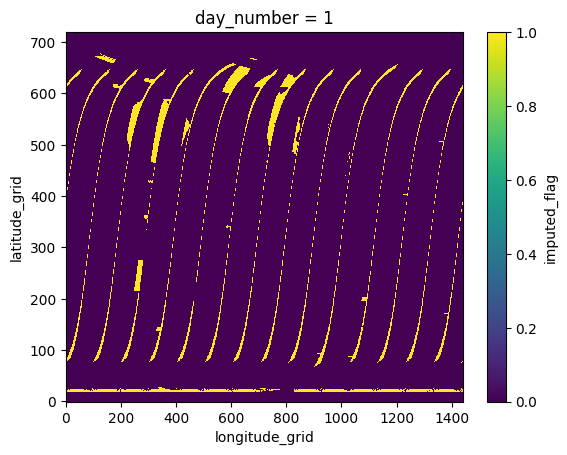

In [7]:
selection = {
    "polarization": 1,
    "frequency_band" : 0,
    "swath_sector" : 1,
    "day_number" : 1
}
ds_imp.imputed_flag.sel(**selection).plot()

--- 
# Test the full pipeline for model preprocessing

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess
windsat_folder = "../../data/raw/daily_Windsat"

# Load all data for both looks
ds = windsat_datacube(windsat_folder)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
ds_model = model_preprocess(ds,swath_sector=0, look="impute", add_look_flag= True)
ds_model

<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...